In [2]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import json
import joblib

<Axes: >

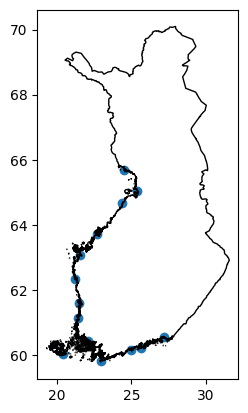

In [20]:
with open('data/fmi/water_temp_stations.json', encoding='utf-8') as f:
    _stations_raw = json.load(f)['FeatureCollection']['member']
_stations = []
for facil in _stations_raw:
    station = facil['EnvironmentalMonitoringFacility']
    name = station["name"][0]
    loc = station["representativePoint"]['Point']["pos"]
    lat, long = loc.split(' ')
    _stations.append({
        "name": name,
        "geometry": Point(float(long), float(lat)),
    })
water_temp_stations = gpd.GeoDataFrame(_stations, crs="EPSG:4326")
bound = gpd.read_file('data/wind/finland.geojson')
map_ = bound.plot(color='none', edgecolor='black', zorder=2)
water_temp_stations.plot(ax=map_)

In [58]:
water_temp_stations.to_file('data/fmi/water_temp_stations.geojson', driver="GeoJSON")

In [3]:
with open('data/fmi/weather_stations_121.json', encoding='utf-8') as f:
    _stations_raw = json.load(f)['FeatureCollection']['member']
with open('data/fmi/weather_stations_224.json', encoding='utf-8') as f:
    _stations_raw.extend(json.load(f)['FeatureCollection']['member'])
_stations = []
for facil in _stations_raw:
    station = facil['EnvironmentalMonitoringFacility']
    name = station["name"][0]
    loc = station["representativePoint"]['Point']["pos"]
    lat, long = loc.split(' ')
    _stations.append({
        "name": name,
        "geometry": Point(float(long), float(lat)),
    })
weather_stations = gpd.GeoDataFrame(_stations, crs="EPSG:4326")
weather_stations.to_file('data/fmi/weather_stations.geojson', driver="GeoJSON")


In [51]:
coastline = gpd.read_file('data/poi/coastline.geojson')

In [52]:
# Convert to projected CRS for distance calc
coastline_proj = coastline.to_crs("EPSG:3067")
water_temp_stations_proj = water_temp_stations.to_crs("EPSG:3067")

In [54]:
coastline_proj = coastline_proj.sample_points(5)

In [56]:
from tqdm import tqdm

In [57]:
# bbox 58.85, 19.09, 70.09, 31.58

def water_prox(long, lat):
    point = Point(long, lat)
    # # check if point is within finland
    # if not bound.contains(point).any():
    #     return None
    # distance to closest coastline
    dist = coastline_proj.distance(point).min()
    # closest water temperature station
    closest = water_temp_stations_proj.distance(point).idxmin()
    return {
        "geometry": point,
        "coast_dist": dist,
        "water_temp_station": closest,
    }

# iterate through bounding box
proximities = (
    water_prox(long, lat)
    for long in np.arange(19.09, 31.58, 0.05)
    for lat in np.arange(58.85, 70.09, 0.05)
)


proximities = gpd.GeoDataFrame(tqdm(proximities))
proximities.head()

24248it [41:26,  9.75it/s]


KeyboardInterrupt: 